# ASI assessed exercise 2016/2017

#### Student: <b>Gaballo</b> Alessandro

## 1. Introduction

In [1]:
# keras and tensorflow are required
from keras.datasets import mnist
from keras.datasets import cifar10
from time import time
from scipy.stats import norm
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, mean_squared_error

Using TensorFlow backend.


 <b>Q1.</b> Download the MNIST and CIFAR10 datasets and import them.

In [2]:
(mnist_train, mnist_train_label), (mnist_test, mnist_test_label) = mnist.load_data()
(cifar_train, cifar_train_label), (cifar_test, cifar_test_label) = cifar10.load_data()

<b>Q2.</b> Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.

In [3]:
mnist_training_count, bins = np.histogram(mnist_train_label, bins=10)
mnist_test_count, bins = np.histogram(mnist_test_label, bins=10)

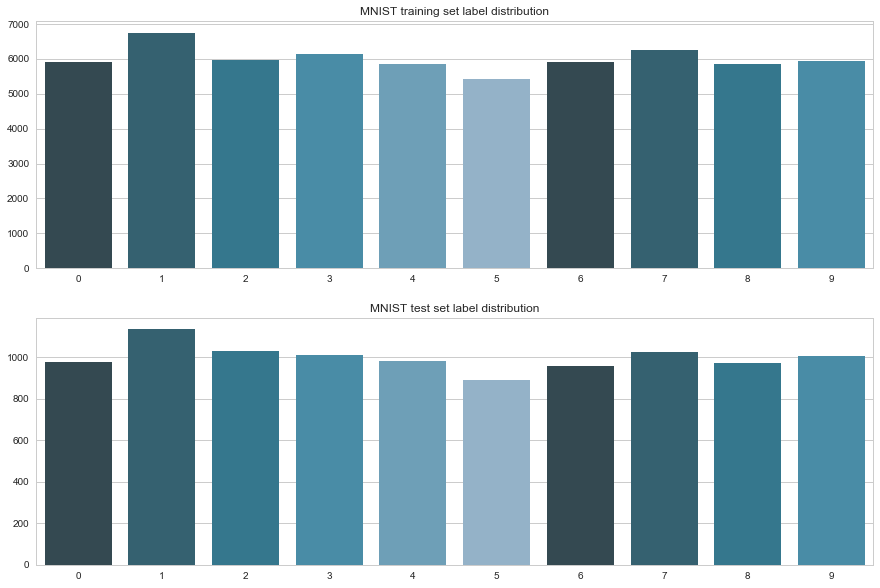

In [4]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title("MNIST training set label distribution")
sns.barplot(np.arange(10), mnist_training_count, palette=sns.color_palette("PuBuGn_d"))
plt.xticks(np.arange(10))
plt.subplot(212)
plt.title("MNIST test set label distribution")
sns.barplot(np.arange(10), mnist_test_count, palette=sns.color_palette("PuBuGn_d"))
plt.xticks(np.arange(10))
plt.show()

In [5]:
print("MNIST data shape: {}".format(mnist_test.shape))
print("MNIST labels shape: {}".format(mnist_test_label.shape))

MNIST data shape: (10000, 28, 28)
MNIST labels shape: (10000,)


<div class='alert alert-info'>The previous figures show the label distribution in both the MNIST training and test set; in general an uneven distribution of the classes could lead to the <a href="https://en.wikipedia.org/wiki/Accuracy_paradox">Accuracy Paradox</a>, where the accuracy measures tell the story that you have excellent accuracy (such as 90%), but the accuracy is only reflecting the underlying class distribution. In our case, even if the distribution is not even, the difference is not huge so there won't be any problem.
<br><br>
Concerning the dimensionality, the MNIST dataset is composed as follows:<br>
$60000$ images for training, shape $\left(28, 28\right)$, $10000$ images for testing, same shape.<br>
Each image will be handled as an array (obtained by flattening the matrix), so each sample will have a shape of $(784, 1)$. The values in the array vary belong to $\left[0, 255\right]$, they need to be handled properly in order not to cause overflow/underflow problem.
</div>

In [6]:
cifar_training_count, bins = np.histogram(cifar_train_label, bins=10)
cifar_test_count, bins = np.histogram(cifar_test_label, bins=10)

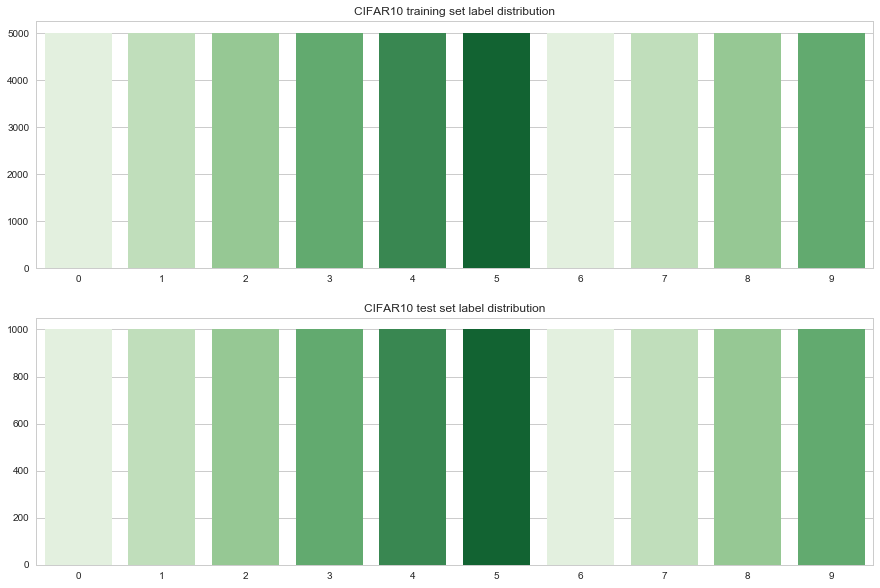

In [7]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title("CIFAR10 training set label distribution")
sns.barplot(np.arange(10), cifar_training_count, palette=sns.color_palette("Greens"))
plt.xticks(np.arange(10))
plt.subplot(212)
plt.title("CIFAR10 test set label distribution")
sns.barplot(np.arange(10), cifar_test_count, palette=sns.color_palette("Greens"))
plt.xticks(np.arange(10))
plt.show()

In [8]:
print("CIFAR10 data shape: {}".format(cifar_test.shape))
print("CIFAR10 labels shape: {}".format(cifar_test_label.shape))

CIFAR10 data shape: (10000, 32, 32, 3)
CIFAR10 labels shape: (10000, 1)


<div class='alert alert-success'>The previous figures show the label for the CIFAR10 dataset; in this case the label distribution is even in both the training and test set so there shouldn't be any problem.
<br><br>
Concerning the dimensionality, the CIFAR10 dataset is composed as follows:<br>
$50000$ images for training, shape $\left(32, 32, 3\right)$, $10000$ images for testing, same shape.<br>
Each image will be handled as an array (obtained by flattening the matrix), so each sample will have a shape of $(3072, 1)$. The values in the array vary belong to $\left[0, 255\right]$, they need to be handled properly in order not to cause overflow/underflow problem.<br>
<div class='label label-warning'>NOTE:</div> With the CIFAR10 dataset we have much bigger data to handle (3072 instead of 784), that means that overflow/underflow problems are more likely to happen. Countermeasures for these problems will be described in the following questions.
</div>

## 2. Classification

###### Q1. Implement the Naive Bayes Classifier


The naïve Bayes classifier is a very simple probabilistic classifier based on Bayes rule:
<br><br>
\begin{equation}
P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )
= \frac {P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
        {\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
\end{equation}

To make the predictions three elements are needed:
<ul>
    <li>Likelihood: $P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ )$ which defines how likely it is to "see" $\mathbf{x}_{new}$ given $t_{new}=k$</li>
    <li>Prior: $P( \ t_{new}=k \ )$ which defines the apriori probability of finding a certain label $k$</li>
    <li>Marginal: $\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ ) = P(\ \mathbf{x}_{new} \ )$ that is a normalization factor that does not influence the predictions
</ul>
In the following implementation I decided to use a multivariate Bernoulli event model for the conditional distributions of the labels:
\begin{equation}
{\displaystyle p(\mathbf {x} \mid t_{k})=\prod _{i=1}^{n}p_{ki}^{x_{i}}(1-p_{ki})^{(1-x_{i})}}
\end{equation}
Assume that within each class, the individual pixel values are independent:
\begin{equation}
P_{ki} (x_{i}) = \begin{cases} p_{ki} & \mbox{if } x_{i}=1\\ 1-p_{ki} & \mbox{if } x_{i}=0 \end{cases}
\end{equation}
$p_{ki}$ will be estimated as follows:

\begin{equation}
n_{k} = \text{# of examples of class } k
\end{equation}

\begin{equation}
n_{ik} = \text{# of examples of class } k\ \text{with } x_{i}=1
\end{equation}

\begin{equation}
\hat{p_{ki}} = \frac{n_{ik}}{n_{k}}
\end{equation}

Predictions will be made as follows:
<ol>
<li>Given a sample $\mathbf{x}_{new}$ compute the posterior $P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )$ for each $k$</li>
<li>Compute the new label:
\begin{equation}
    t_{new} = \arg\max_{k} \pi_{k}\ P(k)
\end{equation}
being $\pi_{k}$ the prior for label $k$ and $P(k)$ the posterior conditioned on $k$
</li>
<ol>
<br><br>

In [9]:
class NaiveBayesClassifier(object):
    def __init__(self, normalize='continuous'):       
        self.normalize = normalize
        self.prior = []
        self.mean_var = {}
        print("Created new instance of Naive Bayes Classifier")
    
    # computing prior for each label in the training set
    def _prior(labels):
        num_labels = len(np.unique(labels))
        label, counts = np.unique(labels, return_counts = True)
        priors = np.zeros(num_labels)
        for i in range(num_labels):
            priors[label[i]] = counts[i]
        return priors/len(labels)
    
    # ---- Bernoulli naive Bayes  ----#
    def _partial(data):
        count = {}
        # computing conditional probability for each label
        for digit in data:
            # using Laplace smoothing in case all the pixels are black/white
            count[digit] = (np.count_nonzero(data[digit], axis=0)+1)/(len(data[digit])+2)
        return count
    
    def _likelihood(self, sample):
        # log is used in order to not incurr in underflow problems
        def _log_like(partial, x):
            return x*np.log(partial) + ((1-x)*np.log(1-partial))
            
            
        sample = sample.flatten()
        likelihoods = np.float128(np.zeros(10))
        for digit in self.partial:
            likelihoods[digit] = np.sum(_log_like(self.partial[digit], sample))
        return likelihoods
    
       
    def _posterior(self, likelihoods):
        return np.sum([np.log(self.prior), likelihoods], axis=0)
    # ------------------ #    

#     ---- Gaussian naive Bayes  ----#
#     def _mean_var(data):
#         mean_var = {}
#         for digit in data:
#             mean = np.mean(data[digit], axis=0)
#             var = np.var(data[digit], axis=0) + 1e-3 #make sure not to have 0 value variance
#             mean_var[digit]=(mean, var)
#         return mean_var

#     def _likelihood(self, sample):
#         def _log_normal(mean, var, x):
#             return np.sum(np.float128((-0.5 * np.log(2 * np.pi * var)) -(x - mean)**2 / (2 * var)))

        
#         sample = sample.flatten()
#         likelihoods = np.float128(np.zeros(10))
#         for i, (mean, var) in enumerate(self.mean_var.values()):
#             likelihoods[i] = np.sum(_log_normal(mean, var, sample))
#         return likelihoods
    
#     def _marginal(self, likelihoods):
#         return np.sum(np.multiply(likelihoods, self.prior))
    
#     def _posterior(self, likelihoods, marginal):
#         return self.prior + likelihoods - marginal

    # ------------------ #    

    
    def fit(self, data, labels):
        t0 = time()
        data_norm = data
        # considering the pixel to be either 0 or 1 [needed for Bernoulli approach]
        if self.normalize == 'binary':
            data_norm = np.round(data / 255)
        else:
            # data will vary between 0 and 1, in this way overflow will be avoided
            data_norm = data / 255

        #computing prior probabilities for different classes
        self.prior = NaiveBayesClassifier._prior(labels)
        
        # grouping all the images of each digit
        # digits_imgs contains the list of images(flattened) for each digit 
        digits_imgs = {label:[] for label in np.unique(labels)}
        for img, label in zip(data_norm, labels):
            digits_imgs[label].append(img.flatten())
        # computing the conditional probability
        self.partial = NaiveBayesClassifier._partial(digits_imgs)
        t1 = time()
        print('Training time {:.3f} s'.format(t1-t0))


    def predict(self, data, probability=False):
        t0 = time()
        data_norm = data
        if self.normalize == 'binary':
            data_norm = np.round(data / 255)
        else:
            data_norm = data / 255
        
        predictions = []
        for sample in data_norm:
            likelihoods = self._likelihood(sample)
            posterior = self._posterior(likelihoods)
            predictions.append(posterior)

        t1 = time()
        print('Classification time {:.3f} s'.format(t1-t0))

        if probability:
            # returning the predictions for each label
            return predictions
        else:
            # returning the predicted label
            pred_labels = [np.argmax(posterior) for posterior in predictions]
        return pred_labels
    
    def pred_proba(self, data):
        return self.predict(data, probability=True)

###### Q2. Describe a positive and a negative feature of the classifier for these tasks

<div class='alert alert-info'>
A positive feature of the Naive Bayes classifier is that it's really simple because it's all about counting. If the conditional independence assumption holds, a Naive Bayes classifier will converge quicker than discriminative models like logistic regression, so less training data are needed. In practice a Naive Bayes classifier performs well even if independence assumption doesn't hold.
<br><br>
One  negative aspect of Naive Bayes classifier is that its performance are strongly related to the quality of the training data, meaning that an unbalanced distribution of the labels in the training set will produce biased predictions. Moreover it works with probabilites that go towards 0 or 1, which could lead to numerical instabilities and consequently worse results.
</div>

###### Q3. Describe any data pre-processing that you suggest for this data and your classifier
<div class='alert alert-info'>
Given the dimensionality of the data and the range of values, a normalization process is applied to the data itself. Two ways of normalization have been defined, $binary$ normalization reduce the pixels value in $ \left\{ 0, 1\right\} $, $continuous$ do the same in $\left[0, 1\right]$.<br>
By reducing the interval of variation of data the overflow issue was addressed, in order not to have underflow problems the log likelihood has been used.
When trying the Gaussian Naive Bayes another problem came up, the so called <i>zero frequency problem</i>, which occurs when a certain label and attribute value don't appear together causing the frequency-based probability to be 0. To solve the problem a small offset was added to all the variances.
</div>

###### Q4. Apply your classifier to the two given datasets. Make sure your optimization is clearly commented. <br>Use classification accuracy and test log-likelihood as your figures of merit

In [10]:
mnist_classifier = NaiveBayesClassifier(normalize='binary')
mnist_classifier.fit(mnist_train, mnist_train_label)

mnist_predicted =  mnist_classifier.predict(mnist_test)
mnist_predicted_prob = mnist_classifier.pred_proba(mnist_test)
print("Classification accuracy {:.2f}%".format(accuracy_score(mnist_test_label, mnist_predicted)*100))
print("Classification log-likelihood {:.2f}%".format(log_loss(mnist_test_label, mnist_predicted_prob)))

Created new instance of Naive Bayes Classifier
Training time 1.079 s
Classification time 6.519 s
Classification time 6.490 s
Classification accuracy 84.27%
Classification log-likelihood 2.30%


<div class="alert alert-warning">
I implemented the class $NaiveBayesClassifier$ which will work on a flattened version of the images, that means that it doesn't matter if the format of the input is grayscale (<b>mnist</b>) or rgb (<b>cifar</b>) because the corresponding matrix/matrixes will be transformed in a monodimensional array. On the other hand I need to reshape the CIFAR10's labels because they have a different format, the transformation will be:<br> 

Training set: $(50000, 1) \rightarrow (50000,)$<br>
Test set: $(10000, 1) \rightarrow (10000,)$<br>
so that our classifier will work indiscriminately with both of the dataset.
</div>

In [11]:
cifar_train_label = cifar_train_label.reshape((len(cifar_train_label,)))
cifar_test_label = cifar_test_label.reshape((len(cifar_test_label,)))

In [12]:
cifar_classifier = NaiveBayesClassifier(normalize='binary')
cifar_classifier.fit(cifar_train, cifar_train_label)
cifar_predicted = cifar_classifier.predict(cifar_test)
cifar_predicted_prob = cifar_classifier.pred_proba(cifar_test)
print("Classification accuracy {:.2f}%".format(accuracy_score(cifar_test_label, cifar_predicted)*100))
print("Classification log-likelihood {:.2f}%".format(log_loss(cifar_test_label, cifar_predicted_prob)))

Created new instance of Naive Bayes Classifier
Training time 3.721 s
Classification time 18.091 s
Classification time 17.838 s
Classification accuracy 28.03%
Classification log-likelihood 2.30%


###### Q5. Display the confusion matrix on the test data

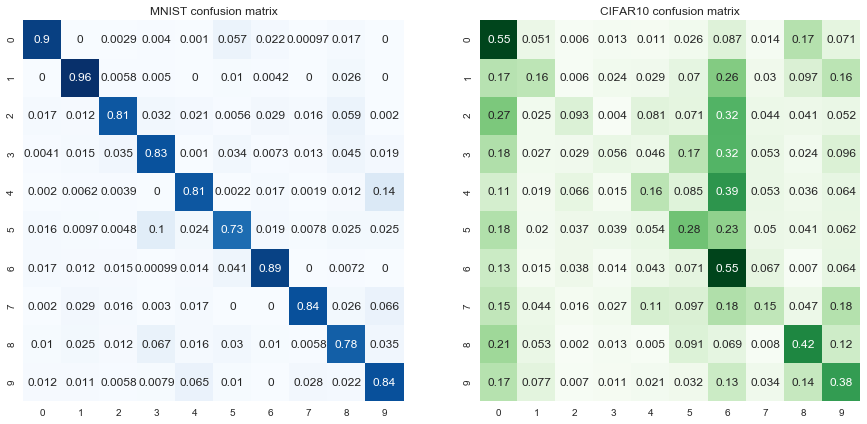

In [61]:
mnist_conf = confusion_matrix(mnist_test_label, mnist_predicted)
mnist_conf_norm = mnist_conf / mnist_conf.sum(axis=1)
cifar_conf = confusion_matrix(cifar_test_label, cifar_predicted)
cifar_conf_norm = cifar_conf / cifar_conf.sum(axis=1)
fig, axes = plt.subplots(1,2,figsize=(15, 7))
matrixes = [mnist_conf_norm, cifar_conf_norm]
titles = ["MNIST confusion matrix", "CIFAR10 confusion matrix"]
cmaps=['Blues', 'Greens']
for k, ax in enumerate(axes.flatten()):
    ax.set_title(titles[k])
    sns.heatmap(matrixes[k], cbar=False, cmap=cmaps[k], annot=True, yticklabels=np.arange(10), ax=ax)
plt.show()

<div class='alert alert-info'>
From the comparison of the two confusion matrixes it's evident how the classifier works better on the MNIST dataset.
</div>

###### Q6. Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved 

In [64]:
mnist_rand_labels = np.random.randint(0, 9, len(mnist_test_label))
cifar_rand_labels = np.random.randint(0, 9, len(cifar_test_label))
print("Random MNIST classifier accuracy: {:.2f}%".format(accuracy_score(mnist_test_label, mnist_rand_labels)*100))
print("Random CIFAR10 classifier accuracy: {:.2f}%".format(accuracy_score(cifar_test_label, cifar_rand_labels)*100))

Random MNIST classifier accuracy: 10.13%
Random CIFAR10 classifier accuracy: 10.22%


## 3. Linear Regression

###### Q1. Implement Bayesian linear regression

In [7]:
class BayesianLinearRegression(object):
    def __init__(self, normalize=True):
        self._normalize = normalize
        print("Create new instance of Bayesian Linear Regression")

    def _X(data, order):
        data = data.reshape(-1, np.prod(data[0].shape))
        X = np.ones(data.shape)
        for i in range(1,order+1):
            X = np.hstack((X, np.power(data, i)))
        return X
        
    def fit(self, data, labels, order=1):
        t0 = time()
        self.order = order
        if self._normalize:
            data = data / 255
            
        X = BayesianLinearRegression._X(data, order)
        X_t = X.T
        shape = X.shape[1]
        noise = np.diag(np.random.uniform(0, 1, shape ))
        self._inv = np.linalg.inv(X_t.dot(X) + noise)
        self.w_hat = self._inv.dot(X_t).dot(labels)
        tXw = labels - X.dot(self.w_hat)
        self.sig_hat = tXw.T.dot(tXw)/len(labels)
        t1 = time()
        print("Built model in {:.2f} seconds".format(t1-t0))
        return
    
    def predict(self, data):
        t0 = time()
        if self._normalize:
            data = data / 255
            
        X = BayesianLinearRegression._X(data, self.order)
        X_t = X.T
        predictions = X.dot(self.w_hat)
        var = []
        for x in X:
            var.append(self.sig_hat*x.T.dot(self._inv).dot(x))
#         predictions = np.round(X.dot(self.w_hat))
#         predictions = np.array([0 if p < 0 else 9 if p > 9 else p for p in predictions])
        t1 = time()
        print("Classification time {:.2f} seconds".format(t1-t0))
        return (predictions, var)

###### Q2. Treat class labels as continuous and apply regression to the training data

In [10]:
mnist_blr = BayesianLinearRegression()
mnist_blr.fit(mnist_train, mnist_train_label, order=3)
mnist_predicted_blr, mnist_var = mnist_blr.predict(mnist_test)

Create new instance of Bayesian Linear Regression
Built model in 47.72 seconds
Classification time 76.62 seconds


In [8]:
cifar_blr = BayesianLinearRegression()
cifar_blr.fit(cifar_train, cifar_train_label, order=1)
cifar_predicted_blr, cifar_var = cifar_blr.predict(cifar_test)

Create new instance of Bayesian Linear Regression
Built model in 194.48 seconds
Classification time 278.07 seconds


###### Q3. Produce a scatter plot showing the predictions versus the true targets for the test set and compute the mean squared error on the test set 

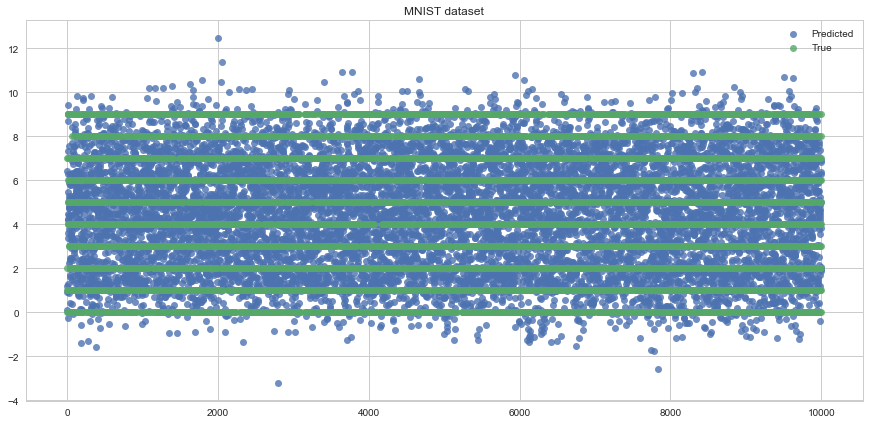

MNIST Mean squared error: 2.47


In [11]:
plt.figure(figsize=(15,7))
sns.regplot(np.arange(len(mnist_predicted_blr)), mnist_predicted_blr, fit_reg=False, label='Predicted')
sns.regplot(np.arange(len(mnist_predicted_blr)), mnist_test_label, fit_reg=False, label='True')
plt.title("MNIST dataset")
plt.legend()
plt.show()
msq = mean_squared_error(mnist_test_label, mnist_predicted_blr)
print("MNIST Mean squared error: {:.2f}".format(msq))

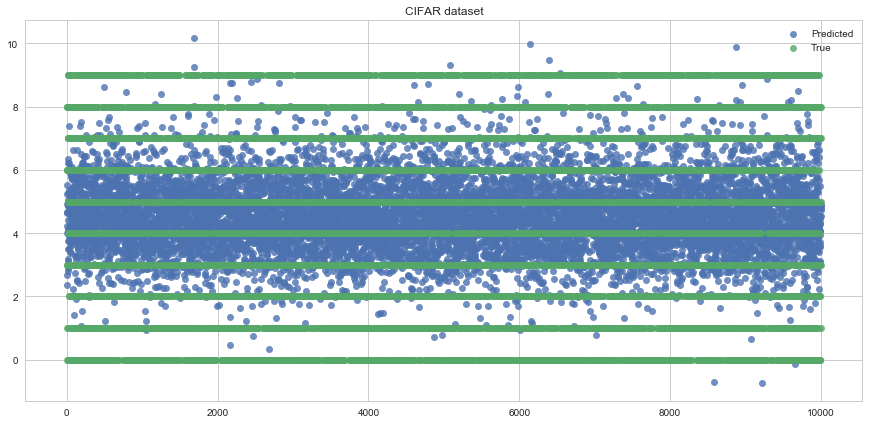

CIFAR Mean squared error: 7.90


In [12]:
plt.figure(figsize=(15,7))
sns.regplot(np.arange(len(cifar_predicted_blr)), cifar_predicted_blr, fit_reg=False, label='Predicted')
sns.regplot(np.arange(len(cifar_test_label)), cifar_test_label, fit_reg=False, label='True')
plt.title("CIFAR dataset")
plt.legend()
plt.show()
msq = mean_squared_error(cifar_test_label, cifar_predicted_blr)
print("CIFAR Mean squared error: {:.2f}".format(msq))

###### Q4. Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy

Intuitevely the first way to discretize the predictions would be to round the result to the closest integer, however there's still a problem left, we need to decide how the handle the predictions that satisfy the following:

$ t_{new} \in \left [-	\infty, 0 \right [ \quad \vee \quad t_{new} \in \left ]9, +\infty\right ]$

The simplest thing 

###### Q5. Discuss regression performance with respect to classification performance

###### Q6. Describe one limitation of using regression for this particular task